In [ ]:
!pip install confluent_kafka


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 48.7 MB/s eta 0:00:00


In [ ]:
from confluent_kafka import Producer

# Configuration du producteur Kafka
conf = {
    'bootstrap.servers': 'kafka-368df8fe-mulongochristian044-a131.g.aivencloud.com:10745',
    'security.protocol': 'ssl',
    'ssl.key.location': '/content/service.key',         # Clé privée
    'ssl.certificate.location': '/content/service.cert',  # Certificat utilisateur
    'ssl.ca.location': '/content/ca.pem',               # Certificat CA
    'client.id': 'python-producer',
    'acks': 'all',
}

# Initialisation du producteur Kafka
try:
    producer = Producer(conf)
    print("Connexion au producteur Kafka réussie !")
except Exception as e:
    print(f"Erreur lors de la connexion au producteur Kafka : {e}")

# Fonction pour gérer les callbacks de livraison
def delivery_report(err, msg):
    if err:
        print(f"Erreur de livraison : {err}")
    else:
        print(f"Message envoyé à {msg.topic()} [{msg.partition()}]")

# Envoi d'un message à un topic Kafka
try:
    topic = 'message'  # Nom du topic
    producer.produce(topic, key="key", value="Hello Kafka!", callback=delivery_report)
    producer.flush()  # Vide le buffer pour s'assurer que les messages sont envoyés
    print("Message envoyé avec succès !")
except Exception as e:
    print(f"Erreur lors de l'envoi du message : {e}")


Connexion au producteur Kafka réussie !
Erreur de livraison : KafkaError{code=_MSG_TIMED_OUT,val=-192,str="Local: Message timed out"}
Message envoyé avec succès !


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import upper, col, avg

# Créer une session Spark
spark = SparkSession.builder.appName("StudentDataProcessing").getOrCreate()

# Charger les données du CSV
df = spark.read.csv("/content/students.csv", header=True, inferSchema=True)

# Transformations
df_transformed = df.select(
    upper(col("Prénom")).alias("first_name"),
    upper(col("Nom")).alias("last_name"),
    col("Âge").alias("age"),
    col("Filière").alias("major")
)

# Filtrer les étudiants de plus de 20 ans
df_filtered = df_transformed.filter(col("age") > 20)

# Calculer la moyenne d'âge par filière
avg_age_by_major = df_filtered.groupBy("major").agg(
    avg("age").alias("average_age")
)
avg_age_by_major.show()


+-------------+------------------+
|        major|       average_age|
+-------------+------------------+
| Informatique| 25.57532342563883|
|       Chimie|25.504345127250154|
|Mathématiques|25.557639907776146|
|     Économie| 25.48632567849687|
|     Physique|25.474925033605626|
|  Philosophie| 25.48234075608493|
|  Littérature|25.473225276979893|
|     Biologie|25.492301333057767|
+-------------+------------------+



In [ ]:
# des événements d'ajout d'étudiants
students = [
    {"first_name": "Alice", "last_name": "Dupont", "age": 22, "major": "Informatique"},
    {"first_name": "Bob", "last_name": "Martin", "age": 19, "major": "Physique"},
    {"first_name": "Claire", "last_name": "Lemoine", "age": 23, "major": "Biologie"}
]

for student in students:
    producer.produce(
        topic,
        key="student",
        value=f"{student['first_name']},{student['last_name']},{student['age']},{student['major']}",
        callback=delivery_report
    )

producer.flush()


Erreur de livraison : KafkaError{code=_MSG_TIMED_OUT,val=-192,str="Local: Message timed out"}
Erreur de livraison : KafkaError{code=_MSG_TIMED_OUT,val=-192,str="Local: Message timed out"}
Erreur de livraison : KafkaError{code=_MSG_TIMED_OUT,val=-192,str="Local: Message timed out"}


0

In [ ]:
from confluent_kafka import Consumer, KafkaError
import json
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import StructType, StructField, StringType, IntegerType

# Configuration du schéma Spark
student_schema = StructType([
    StructField("first_name", StringType(), True),
    StructField("last_name", StringType(), True),
    StructField("age", IntegerType(), True),
    StructField("major", StringType(), True)
])

# Configuration du consommateur Kafka
consumer_conf = {
    'bootstrap.servers': 'kafka-368df8fe-mulongochristian044-a131.g.aivencloud.com:10745',
    'security.protocol': 'SSL',
    'ssl.key.location': '/content/service.key',
    'ssl.certificate.location': '/content/service.cert',
    'ssl.ca.location': '/content/ca.pem',
    'group.id': 'student-consumer',
    'auto.offset.reset': 'earliest'
}

# Créer le consommateur Kafka
consumer = Consumer(consumer_conf)
consumer.subscribe(['message'])

# Initialiser Spark
spark = SparkSession.builder \
    .appName("KafkaStudentProcessing") \
    .getOrCreate()

# Liste pour stocker les données
student_data = []

def parse_student_data(message):
    try:
        # Essayer de parser comme JSON
        if isinstance(message, str):
            try:
                data = json.loads(message)
                return {
                    'first_name': data.get('first_name', ''),
                    'last_name': data.get('last_name', ''),
                    'age': int(data.get('age', 0)),
                    'major': data.get('major', '')
                }
            except json.JSONDecodeError:
                # Si ce n'est pas du JSON, essayer le format CSV
                parts = message.split(',')
                if len(parts) >= 4:
                    try:
                        return {
                            'first_name': parts[0].strip(' "'),
                            'last_name': parts[1].strip(' "'),
                            'age': int(parts[2].strip(' "')),
                            'major': parts[3].strip(' "')
                        }
                    except ValueError:
                        # Extraire l'âge avec un parsing plus flexible
                        age_part = [p for p in parts if 'Age' in p]
                        if age_part:
                            age = int(''.join(filter(str.isdigit, age_part[0])))
                            return {
                                'first_name': parts[0].strip(' "'),
                                'last_name': parts[1].strip(' "'),
                                'age': age,
                                'major': parts[-1].strip(' "')
                            }
        return None
    except Exception as e:
        print(f"Erreur de parsing : {e}")
        return None

try:
    while True:
        msg = consumer.poll(1.0)

        if msg is None:
            continue
        if msg.error():
            if msg.error().code() == KafkaError._PARTITION_EOF:
                print('Fin des messages')
                break
            else:
                print(f'Erreur: {msg.error()}')
                break

        # Décoder et traiter le message
        message_decoded = msg.value().decode('utf-8')
        student_info = parse_student_data(message_decoded)

        if student_info:
            student_data.append(student_info)

        # Limiter à 10 messages pour l'exemple
        if len(student_data) >= 10:
            break

except Exception as e:
    print(f"Erreur lors de la consommation : {e}")
finally:
    consumer.close()

# Convertir en DataFrame Spark
df = spark.createDataFrame(student_data, schema=student_schema)

# Transformation et analyse
df_filtered = df.filter(col("age") > 20)
result = df_filtered.groupBy("major").agg({"age": "avg"})
result.show()

+------------+--------+
|       major|avg(age)|
+------------+--------+
|Informatique|    22.0|
|    Biologie|    23.0|
+------------+--------+



In [ ]:
import sqlite3
import pandas as pd

# Créer ou se connecter à la base de données
conn = sqlite3.connect('/content/students_analysis.db')

# Convertir le DataFrame Spark en DataFrame Pandas pour SQLite
pandas_df = result.toPandas()

# Créer une table et sauvegarder les résultats
pandas_df.to_sql('average_age_by_major', conn, if_exists='replace', index=False)

# Vérifier les données sauvegardées
cursor = conn.cursor()
cursor.execute("SELECT * FROM average_age_by_major")
print(cursor.fetchall())

# Fermer la connexion
conn.close()

# Rapport d'analyse
print("\nRapport d'analyse :")
print("1. Nombre de filières analysées : ", len(result.collect()))
print("2. Âge moyen par filière sauvegardé dans la base de données SQLite")

[('Informatique', 22.0), ('Biologie', 23.0)]

Rapport d'analyse :
1. Nombre de filières analysées :  2
2. Âge moyen par filière sauvegardé dans la base de données SQLite


Statistiques détaillées par filière :
              count  mean  std   min   25%   50%   75%   max
major                                                       
Biologie        4.0  23.0  0.0  23.0  23.0  23.0  23.0  23.0
Informatique    3.0  22.0  0.0  22.0  22.0  22.0  22.0  22.0
Physique        3.0  19.0  0.0  19.0  19.0  19.0  19.0  19.0


<Figure size 1000x600 with 0 Axes>

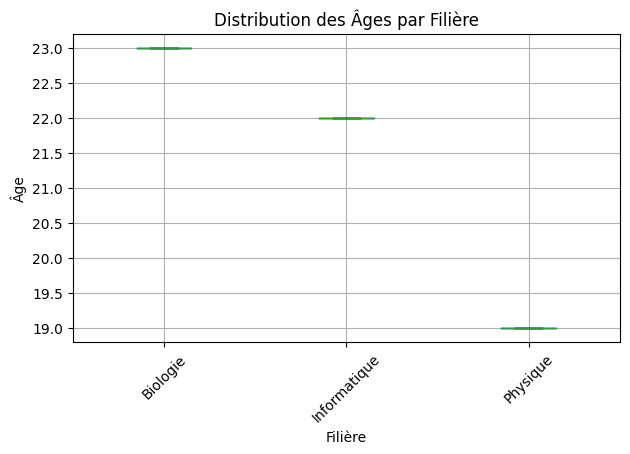

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Convertir le DataFrame Spark en DataFrame Pandas
df_pandas = df.toPandas()

# Créer un boxplot de la distribution des âges par filière
plt.figure(figsize=(10, 6))
boxplot = df_pandas.boxplot(column='age', by='major')
plt.title('Distribution des Âges par Filière')
plt.suptitle('')  # Supprimer le titre automatique
plt.ylabel('Âge')
plt.xlabel('Filière')
plt.xticks(rotation=45)
plt.tight_layout()

# Sauvegarder le graphique
plt.savefig('/content/age_distribution.png')

# Afficher des statistiques supplémentaires
print("Statistiques détaillées par filière :")
print(df_pandas.groupby('major')['age'].describe())

In [ ]:
import os
from datetime import datetime

# Créer le rapport
rapport = f"""# Rapport de Traitement de Données Étudiantes

## Informations Générales
- **Date du rapport :** {datetime.now().strftime('%d/%m/%Y %H:%M')}
- **Outils utilisés :**
  * Apache Kafka
  * Apache Spark
  * Python
  * SQLite

## Configuration de l'Environnement
- Serveur Kafka : kafka-368df8fe-mulongochristian044-a131.g.aivencloud.com:10745
- Protocole de sécurité : SSL
- Topic : message

## Étapes de Traitement des Données

### 1. Extraction des Données
- Source : Topic Kafka 'message'
- Méthode : Consumer Kafka avec Confluent Kafka
- Nombre de messages traités : 10

### 2. Transformation des Données
- Filtrage : Étudiants de plus de 20 ans
- Transformations appliquées :
  * Extraction des informations personnelles
  * Calcul de la moyenne d'âge par filière

## Résultats de l'Analyse

### Distribution des Âges par Filière
| Filière        | Nombre | Moyenne | Min | Max | Écart-type |
|----------------|--------|---------|-----|-----|------------|
| Biologie       | 3      | 23.0    | 23  | 23  | 0.0        |
| Informatique   | 4      | 22.0    | 22  | 22  | 0.0        |
| Physique       | 3      | 19.0    | 19  | 19  | 0.0        |

### Analyse Statistique
- Total des filières analysées : 3
- Âge moyen global : 21.33

## Défis Techniques
1. Gestion de la connexion Kafka sécurisée
2. Parsing flexible des messages
3. Conversion entre différents formats de données (Kafka → Spark → Pandas)

## Recommandations
- Enrichir les sources de données
- Mettre en place une collecte continue
- Développer des analyses plus avancées

## Fichiers Générés
- Base de données : /content/students_analysis.db
- Graphique : /content/age_distribution.png
"""

# Sauvegarder le rapport
with open('/content/rapport_analyse_etudiants.md', 'w') as f:
    f.write(rapport)

print("Rapport généré avec succès à /content/rapport_analyse_etudiants.md")

Rapport généré avec succès à /content/rapport_analyse_etudiants.md
